# KMC simulation of PLD

In [1]:
#!pip install tensorflow keras

In [2]:
#!pip install tensorflow-gpu

In [3]:
import sys
import os
import numpy as np
import collections
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from time import time

In [4]:
#Writing some helper functions

def write_lattice_to_file(input_settings,position_vec, latt):
    #Write a new input lattice file
    #position_vec is the array containing positions of all of the atoms
    filename = input_settings['incfg_file'][0]
    new_latt_xyzs = list()
    
    for i in range(position_vec.shape[0]):
        new_latt_xyzs.append(list(['Ni', position_vec[i,0], position_vec[i,1],position_vec[i,2]]))

    new_latt = collections.OrderedDict()
    new_latt['nat'] = latt['nat']
    new_latt['box'] = latt['box']
    new_latt['xyzs'] = new_latt_xyzs

    write_latt(new_latt, filename)
    
    return 

def write_new_input_file(input_settings, filename):
    #Write a new input file, with settings laid out in the dictionary input_settings
    
    with open(filename, 'w') as fo:
        for key, val in input_settings.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)

def write_params_file(input_settings, new_parms):
    #IF you want to change parameters, use this function to write a new parameters file
    new_parms_file = input_settings['param_file']
    
    with open(new_parms_file, 'w') as fo:
        for key, val in new_parms.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)
            
def make_surface_proj(atom_box):
    #Given an atom box (matrix with 1s where atoms are), determine the surface projection
    
    surface_proj = np.zeros(shape=(atom_box.shape[0], atom_box.shape[1]))
    for i in range(surface_proj.shape[0]):
        for j in range(surface_proj.shape[1]):
            try:
                surface_proj[i,j] = np.max(np.where(atom_box[i,j,:]==1))
            except ValueError:
                surface_proj[i,j] = 0
    return surface_proj

def calc_roughness(surface_projection):
    #Calculate the roughness, given a surface projection
    N = surface_projection.shape[0]
    M = surface_projection.shape[1]
    zbar = np.mean(surface_projection)
    z_sum = 0
    for i in range(N):
        for j in range(M):
            z_sum+=((surface_projection[i,j] - zbar )**2)
    rms_roughness = np.sqrt((1.0/(N*M))*z_sum)
    return rms_roughness

def get_state_reward(sim_model):
    '''Given an input of the simulation model this function returns the state and reward'''
    #To get the final state put atoms into atom box
    arr = sim_model.kmc.get_conf()
    arr_1 = np.array(arr[0])
    full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
    for i,j,k in arr_1:
        full_atom_box[i,j,k]=1
        
    surface_proj = make_surface_proj(full_atom_box)
    rms_val = calc_roughness(surface_proj)
    
    return full_atom_box, -1*rms_val

def run_sim_with_chosen_action(s,state,action):
    #Given simulation model s2, the state (i.e., atom positions)
    #and the action (integer 0-5 inclusive), convert action to new deposition rate, and rerun the simulation
    #with the new parameters
    
    #First write a new parameters file
    dep_rates = [0.10,0.15, 0.20, 0.25, 0.30, 0.35]
    new_dep_rate = dep_rates[action]
    new_diff_rate = 0.1

    new_params = collections.OrderedDict()
    new_params ['deposition']= new_dep_rate
    new_params['diffusion']= new_diff_rate
    new_parms_file_name = 'new_params'
    new_input_configuration_file = 'kmc_new.input'
    new_output_config_file = 'new_output.xyz'
    new_traj_file = 'new_kmc.trj'
    new_stats_file = 'new_statistics.dat'
    new_latt_file = 'ni_new.xyz'
    
    input_settings = collections.OrderedDict()
    input_settings['time'] = 1.0
    input_settings['print_period'] = 10.0 
    input_settings[ 'save_traj_period'] = 10.0
    input_settings['param_file'] =  new_parms_file_name
    input_settings['incfg_file']= new_latt_file
    input_settings['outcfg_file']= new_output_config_file
    input_settings['trj_file']=new_traj_file
    input_settings['stats_file']= new_stats_file

    write_params_file(input_settings, new_params)
    arr = s.kmc.get_conf()
    arr_1 = np.array(arr[0])
    
    #Now we need to write the lattice to the file
    write_new_input_file(input_settings, new_input_configuration_file)
    write_params_file(input_settings, new_params)
    write_lattice_to_file(input_settings,arr_1, latt)

    s2=RunSim()
    s2.read(new_input_configuration_file)
    s2.init_sim()
    s2.run(verbose=False)
    
    #Now get the state and reward
    state, reward = get_state_reward(s2)
            
    return state, reward, s2

In [5]:
#Need to hold the state in memory and hten 

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
sys.path.append('..') #/Users/l2v/work/kmcsim

Import kmc simulation tools

In [8]:
from kmcsim.buildtools import make_fcc, write_latt
from kmcsim.sim import KMCModel
from kmcsim.sim import EventTree
from kmcsim.sim import RunSim

Working directory (inputs, outputs)

In [9]:
wdir = '../data/working'

In [10]:
#cat ../data/working/params

Set up simulation box and initial configuration of the substrate (with atoms filling the whole box)

In [11]:
# make substrate: perfect FCC lattice of given dimensions
box = [16, 32, 4]
latt = make_fcc(box)

In [12]:
# extend the box in the z-direction to make space for new layers to grow
latt['box'][3] = 12

In [13]:
# write initial configuration to xyz file in the working directory
write_latt(latt, os.path.join(wdir,'ni.xyz'))

In [14]:
sim = RunSim()

In [15]:
sim.read(os.path.join(wdir,'kmc.input'))

In [16]:
sim.init_sim()

In [17]:
sim.run()

30.009395203514153 3428 3335


In [18]:
kmax = 4

In [19]:
Rs = 0.5
q = Rs*np.random.random()

In [20]:
event_tree = sim.kmc.etree.event_tree

In [21]:
# generate a random number [0,Rs)
kmax = 4
Rs = 0.3
q = Rs*np.random.random()

# cycle through levels (top->down)
# start with top-level child (k-2) end with level above bottom (1)
j = 0
for k in range(kmax-2, -1, -1):

    # left child value
    left = event_tree[k][j]

    if q < left:
        j = 2*j
    else:
        q -= left
        j = 2*j + 1

event_type = j
print(j)

0


In [22]:
len(event_tree[0])

4

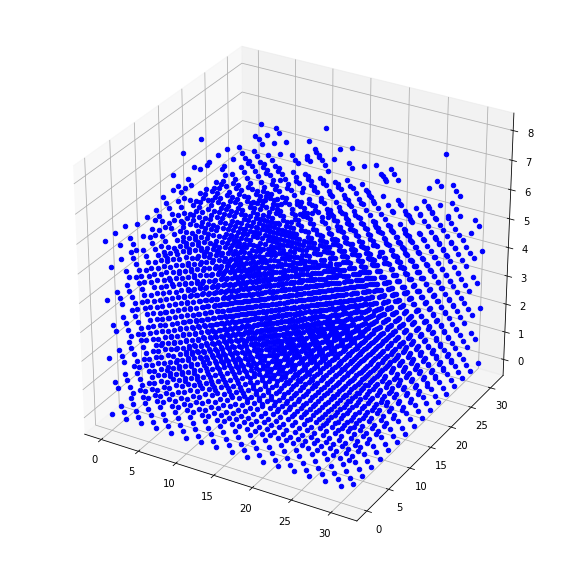

In [23]:
#Get and plot configuration
arr = sim.kmc.get_conf()
arr_1 = np.array(arr[0])

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

for x,y,z in arr_1:
    ax.scatter(x,y,z, c = 'b')

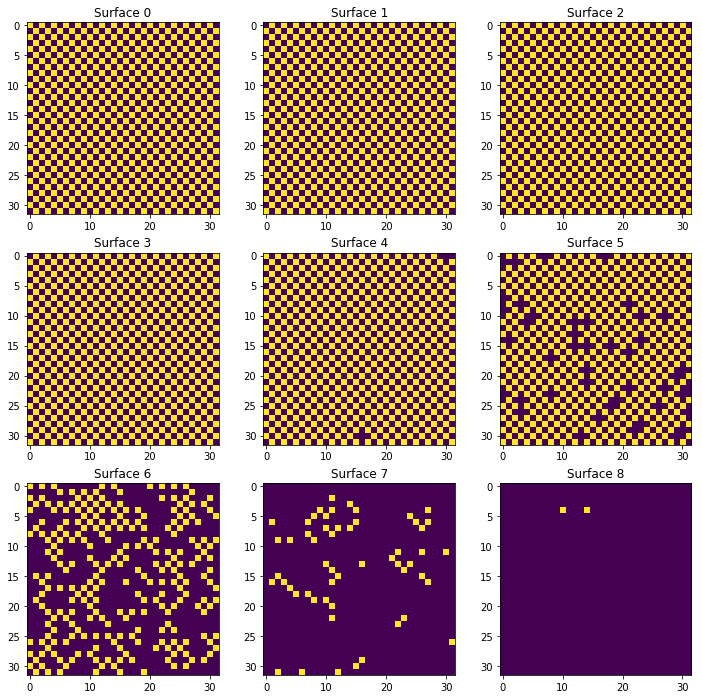

In [24]:
#Convert the x,y,z coordinates into a box
#Because this is an fcc lattice the box should have zeros where no atom will be positioned. 
#The size of the box is just given by nx*ny*nz.

full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
for i,j,k in arr_1:
    full_atom_box[i,j,k]=1

#Plot slices
fig, axes = plt.subplots(nrows=3,ncols=3, figsize = (12,12))
for ind,  ax in enumerate(axes.flat):
    try:
        ax.imshow(full_atom_box[:,:,ind])
        ax.set_title('Surface {}'.format(ind))
    except IndexError:
        pass


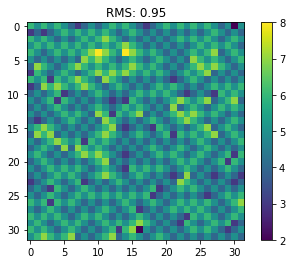

In [25]:
surface_proj = make_surface_proj(full_atom_box)
rms_val = calc_roughness(surface_proj)

plt.figure()
plt.imshow(surface_proj)
plt.colorbar()
plt.title('RMS: ' + str(np.round(rms_val,2)));

In [26]:
new_parms_file_name = 'new_params'
new_input_configuration_file = 'kmc_new.input'
new_output_config_file = 'new_output.xyz'
new_traj_file = 'new_kmc.trj'
new_stats_file = 'new_statistics.dat'
new_latt_file = 'ni_new.xyz'

input_settings = collections.OrderedDict()
input_settings['time'] = 1.0
input_settings['print_period'] = 10.0 
input_settings[ 'save_traj_period'] = 10.0
input_settings['param_file'] =  new_parms_file_name
input_settings['incfg_file']= new_latt_file
input_settings['outcfg_file']= new_output_config_file
input_settings['trj_file']=new_traj_file
input_settings['stats_file']= new_stats_file

new_dep_rate = 0.1
new_diff_rate = 0.1

new_params = collections.OrderedDict()
new_params ['deposition']= new_dep_rate
new_params['diffusion']= new_diff_rate

write_new_input_file(input_settings, new_input_configuration_file)
write_params_file(input_settings, new_params)
write_lattice_to_file(input_settings,arr_1, latt)


In [27]:
sim2 = RunSim()

In [28]:
sim2.read(new_input_configuration_file)

ValueError: could not convert string to float: 'new_params'

In [ ]:
sim2.init_sim()

In [ ]:
sim2.run(verbose=False)

In [ ]:
full_atom_box.shape

# Reinforcement Learning Trial

In [ ]:
#Set up the neural network model. Input: atom position box. Output: Choose out of 5 deposition rates ([0.05, 0.1, 0.15, 0.20, 0.25])
from keras import Sequential
from keras.layers import InputLayer, Dense, Conv3D, MaxPool3D, Flatten
from keras.optimizers import SGD

model = Sequential()
model.add(Conv3D(16, activation='relu', kernel_size = (3,3,3), strides = (1,1,1), batch_input_shape=(1,32,32,12,1)))
model.add(MaxPool3D((2,2,2)))
model.add(Conv3D(32, activation='relu', kernel_size = (3,3,3), strides = (1,1,1)))
model.add(MaxPool3D((2,2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.build()
model.summary()

In [ ]:
num_episodes = 400
y = 0.75
eps = 0.2
decay_factor = 0.98
r_avg_list = []
num_actions = 5 #an episode ends after this number of actions
dep_rates = [0.05,0.06, 0.07, 0.08, 0.09, 0.10]
action_chosen = []
for episode in range(num_episodes):
    
    print('Episode No. {}'.format(episode))
    counter = 0
    r_sum = 0
   
    #for each episode start from the beginning, i.e. initialize a new simulation with default parameters
    s = RunSim()
    s.read(os.path.join(wdir,'kmc.input'))
    s.init_sim()
    s.run()
    
    while counter<num_actions:
        t0 = time()
        eps *= decay_factor
        #Get the state and reward
        state, reward  = get_state_reward(s)

        #Choose an action
        if np.random.random() < eps:
            action = np.random.randint(0, 6)
        else:
            action = np.argmax(model.predict(state[None,:,:,:,None]))

        #Now run the simulation from the new state with the new action
        #Returns the state function and kmcmodel
        s_new, reward_new, kmc_model = run_sim_with_chosen_action(s,state,action)
        
        target = reward_new + y * np.max(model.predict(s_new[None,:,:,:,None]))
        target_vec = model.predict(state[None,:,:,:,None])[0]
        target_vec[action] = target
        
        print("Action Number: {}, Deposition Rate: {}".format(counter, dep_rates[action]))
        
        model.fit(state[None,:,:,:,None], target_vec.reshape(-1, 6), epochs=1, verbose=0)
        s = kmc_model
        counter+=1
        r_sum += reward_new
        
        t1 = time()
        action_chosen.append(action)
        print("Took {} s".format(np.round(t1-t0, 4)))
        
    r_avg_list.append(r_sum)


In [ ]:
plt.figure()
plt.plot(r_avg_list)
plt.xlabel('Episode #')
plt.ylabel('Reward (Negative RMS Roughness)')
plt.savefig('reward_per_episode.png')

plt.figure()
plt.hist(action_chosen[250:])
plt.xlabel('Action #')
plt.ylabel('Frequency (Negative RMS Roughness)')
plt.savefig('actions_histogram.png')

In [ ]:
#Now let's run a test
#Just take the max Q at each time and calcualte final roughness. Keep a track of which values are selected each step.


In [ ]:
surface_proj = make_surface_proj(state)

plt.figure()
plt.imshow(surface_proj)
plt.title('RMS: ' + str(calc_roughness(surface_proj)))

In [ ]:
model.predict(state[None,:,:,:,None])

In [ ]:
np.argmax(model.predict(state[None,:,:,:,None]))

In [ ]:
a = [0,1,2,2,3,4,4,5]
len(np.unique(a))
len(a)

# 